In [84]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import optuna
from optuna.samplers import GPSampler

In [85]:
# Random seed
np.random.seed(42)
torch.manual_seed(42)

In [86]:
# Feedforward network for migration prediction
class MigrationPredictor(nn.Module):
    def __init__(self, hidden_nodes = 64, hidden_layers = 3):
        super().__init__()
        
        n_features = 7
        n_outputs = 4

        # Layer configuration
        layers = []
        # input layer
        layers.append(nn.Linear(n_features, hidden_nodes))
        layers.append(nn.ReLU())

        # hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(nn.ReLU())

        # output layer
        layers.append(nn.Linear(hidden_nodes, n_outputs))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [87]:
# Physical Layers for State update
class PhysicalLayer:
    def __init__(self, dt = 0.1):
        self.dt = dt
    
    def update_state(self, cur_states, migrations):
        # Current States
        T = cur_states[0]
        V = cur_states[1]
        E = cur_states[2]
        CF_LA = cur_states[3]
        CA_LA = cur_states[4]
        CF_K = cur_states[5]
        CB_K = cur_states[6]
        VF = cur_states[7]
        VA = cur_states[8]
        VB = cur_states[9]
        
        # Migration
        dNLA = migrations[0] * self.dt
        dNK = migrations[1] * self.dt
        dVA = migrations[2] * self.dt
        dVB = migrations[3] * self.dt

        # Fixed variables
        nT = T
        nV = V
        nE = E     
        
        # New Volumes
        nVF = VF - dVA - dVB
        nVA = VA + dVA
        nVB = VB + dVB

        # New Concentrations
        nCF_LA = (CF_LA * VF - dNLA) / nVF
        nCA_LA = (CA_LA * VA + dNLA) / nVA
        nCF_K = (CF_K * VF - dNK) / nVF
        nCB_K = (CB_K * VB + dNK) / nVB

        # New States
        new_states = cur_states.clone()
        new_states[0] = nT
        new_states[1] = nV
        new_states[2] = nE
        new_states[3] = nCF_LA
        new_states[4] = nCA_LA
        new_states[5] = nCF_K
        new_states[6] = nCB_K
        new_states[7] = nVF
        new_states[8] = nVA
        new_states[9] = nVB
        
        return new_states

In [88]:
class BMEDDataset(Dataset):
    def __init__(self, dict_spline):
        self.states = ['T', 'V', 'E', 'CF_LA', 'CA_LA', 'CF_K', 'CB_K', 'VF', 'VA', 'VB']
        self.experiments = []

        for exp_id, exp_data in dict_spline.items():
            # Save whole data of each experiment in one sample
            exp_array = exp_data[self.states].values
            times = exp_data['t'].values
            self.experiments.append({
                'init_state': torch.tensor(exp_array[0], dtype = torch.float32), # initial state
                'measured_state': torch.tensor(exp_array, dtype = torch.float32), # whole measurements
                'times': torch.tensor(times, dtype = torch.float32) # time points
            })
    
    def __len__(self):
        return len(self.experiments)
    
    def __getitem__(self, idx):
        return self.experiments[idx]

In [89]:
class BMEDModel(nn.Module):
    def __init__(self, hidden_nodes = 32, hidden_layers = 3, dt = 0.1, scaler = None):
        super().__init__()
        self.migration_predictor = MigrationPredictor(hidden_nodes, hidden_layers)
        self.physical_layer = PhysicalLayer(dt)
        self.scaler = scaler
        self.dt = dt

    def forward(self, init_state, times):

        cur_state = init_state # batch size 1
        cur_time = 0.0
        pred_states = []
        measured_indices = []

        times = times
        times_np = times[0].numpy()
        max_time = times_np[-1]
        measured_indices.append(0)

        # 초기 상태 저장
        pred_states.append(cur_state)

        while cur_time < max_time:
            # input_feature에 해당하는 변수만 정규화
            input_state = cur_state[:, :7]  # input feature 추출, 2차원 유지지
            
            norm_input = self.scaler.transform(input_state.detach().numpy())
            norm_input = torch.tensor(norm_input)
            
            # 상태 예측
            migration = self.migration_predictor(norm_input)  # (1, 6) -> (1, 3)
            cur_state = self.physical_layer.update_state(cur_state[0], migration[0]).unsqueeze(0)  # (1,8)
            pred_states.append(cur_state)  # (1, 8)
            cur_time += self.dt

            # 측정 시간과 매칭
            for t in times_np:
                if abs(cur_time - t) < self.dt/2:
                    measured_indices.append(len(pred_states) - 1)

        # 현재 배치의 예측 상태들을 스택
        pred_states = torch.cat(pred_states, dim=0)  # (n_steps, 8)

        return pred_states, measured_indices

In [90]:
def custom_loss(pred_states, measured_indices, measured_states):
    total_loss = 0
    for idx, measured_state in zip(measured_indices, measured_states[0]):
        predicted_state = pred_states[idx]
        total_loss += torch.mean((predicted_state - measured_state) ** 2)

    return total_loss

In [122]:
def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0
    num_exp = 0

    with torch.no_grad():
        for exp in val_loader:
            init_state = exp['init_state']
            measured_states = exp['measured_state']
            times = exp['times']

            pred_states, measured_indices = model(init_state, times)
            

            loss = custom_loss(pred_states, measured_indices, measured_states)
            total_loss += loss.item()
            num_exp += 1

    avg_loss = total_loss / num_exp


    return avg_loss

In [125]:
def train_model(model, train_loader, val_loader,epochs = 100, learning_rate = 0.001, weight_decay = 1e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay= weight_decay)

    patience = max(epochs // 10, 10)
    min_delta = 0.0001

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()

        for exp in train_loader:
            optimizer.zero_grad()

            init_state = exp['init_state']
            measured_state = exp['measured_state']
            times = exp['times']

            # Simulation
            pred_state, measured_indices = model(init_state, times)

            # Loss
            loss = custom_loss(pred_state, measured_indices, measured_state)

            loss.backward()
            optimizer.step()

        val_loss = evaluate_model(model, val_loader)

        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if epoch % 10 == 0:
            print(f'Epoch {epoch+1} loss: {loss.item()}, val_loss: {val_loss}, best_loss: {best_val_loss}, patience: {patience_counter}')
        
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            print('\nBest model performance:')
            print(f'  Best val loss: {best_val_loss:.6f}')
            model.load_state_dict(best_model_state)
            break


In [93]:
def r2_calculator(pred_states, measured_indices, measured_states):

    pred_value = pred_states[measured_indices][:,3:].numpy()
    target_value = measured_states[0][:,3:].numpy()
    r2_scores = []
    for col in range(pred_value.shape[1]):
        col_r2 = r2_score(pred_value[:,col], target_value[:,col])
        r2_scores.append(col_r2)

    return np.mean(r2_scores)

In [94]:
def prepare_data(df_path, exp_idx = None):
    # Load raw data
    df = pd.read_csv(df_path)

    if exp_idx is not None:
        df = df[df['exp'].isin(exp_idx)]

    # split the data by experiment number
    dict_spline = {}
    for exp in df['exp'].unique():
        dict_spline[exp] = df[df['exp'] == exp].sort_values('t')

    # scaler
    scaler = StandardScaler()
    col_to_scale = ['T', 'V', 'E', 'CF_LA', 'CA_LA', 'CF_K', 'CB_K']
    scaler.fit(df[col_to_scale].values)
    return dict_spline, scaler

In [95]:
def plot_results(model, dataset, exp_idx=0):
    # 데이터 준비
    exp = dataset.experiments[exp_idx]
    init_state = torch.tensor(exp['init_state'], dtype=torch.float32).unsqueeze(0)
    times = torch.tensor(exp['times'], dtype=torch.float32).unsqueeze(0)
    measured_state = torch.tensor(exp['measured_state'], dtype=torch.float32)
    
    # 예측
    with torch.no_grad():
        pred_states, measured_indices = model(init_state, times)
    
    # 예측을 위한 시간 포인트 생성 (dt = 0.1 간격)
    t_pred = torch.arange(0, times[0][-1].item() + 0.1, 0.1)
    
    # 변수 이름과 단위
    var_names = {
        'T': 'Temperature (°C)',
        'V': 'Voltage (V)',
        'E': 'Electric Field (V/cm)',
        'CF_LA': 'Feed LA Conc. (M)',
        'CA_LA': 'Acid LA Conc. (M)',
        'CF_K': 'Feed K Conc. (M)',
        'CB_K': 'Base K Conc. (M)',
        'VF': 'Feed Volume (L)',
        'VA': 'Acid Volume (L)',
        'VB': 'Base Volume (L)'
    }
    
    # 그래프 그리기
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    axes = axes.ravel()
    
    for i, (var, label) in enumerate(var_names.items()):
        ax = axes[i]
        # 실제 측정값 (점으로 표시)
        ax.plot(times[0].numpy(), measured_state[:, i].numpy(), 
                'bo', label='Measured', markersize=6)
        # 예측값 (연속 선으로 표시)
        ax.plot(t_pred.numpy(), pred_states[:, i].numpy(), 
                'r-', label='Predicted', linewidth=2)
        
        ax.set_title(label, fontsize=12, pad=10)
        ax.set_xlabel('Time (hr)', fontsize=10)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [96]:
def objective(trial):
    # load data
    df_path = '../data/BMED_data_v8.csv'
    dict_spline, scaler = prepare_data(df_path)

    # Hyperparameter 설정
    hidden_nodes = trial.suggest_int('hidden_nodes', 16, 256, step = 16)
    hidden_layers = trial.suggest_int('hidden_layers', 1, 10)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log = True)
    wd = trial.suggest_float('weight_decay', 1e-6, 1e-3, log = True)
    epochs = trial.suggest_int('epochs', 100, 2000, step = 100)
    dt = 0.1

    # 5-fold 설정
    kfolds = 5
    kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)

    # dataset 생성
    dataset = BMEDDataset(dict_spline)

    # k-fold 교차 검증 스코어 저장
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        # kfold로 전체 dataset에 대해서 train과 validation subset을 생성
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Dataloader 생성
        train_loader = DataLoader(train_subset, batch_size = 1, shuffle = True)
        val_loader = DataLoader(val_subset, batch_size = 1, shuffle = False)

        # 모델 생성
        model = BMEDModel(hidden_nodes=hidden_nodes, hidden_layers=hidden_layers, dt = dt, scaler=scaler)

        # 모델 학습
        train_model(model = model, train_loader = train_loader, epochs = epochs, learning_rate = lr, weight_decay = wd)   

        # 모델 평가
        r2_score = evaluate_model(model, val_loader)  
        fold_scores.append(r2_score)
    
    return np.mean(fold_scores)
    

In [97]:
# generate study with gaussian process sampler
storage_name = f'sqlite:///hpOpt.db'
sampler = GPSampler(n_startup_trials=10, seed=42)
n_trials = 100
study = optuna.create_study(
    study_name = 'hpOpt',
    storage = storage_name,
    direction='maximize',
    sampler=sampler,
    load_if_exists = True)

# optimize the hyperparameters
study.optimize(objective, n_trials=n_trials)

# return the best hyperparameters
best_params = study.best_trial.params
best_value = study.best_value

# optimize the model with the best hyperparameters
results = {
    'best_params': best_params,
    'best_value': best_value,
    'study': study
}



C:\Users\bsjun\AppData\Local\Temp\ipykernel_37328\2405133046.py:3: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler = GPSampler(n_startup_trials=10, seed=42)
[I 2025-04-23 01:27:19,009] Using an existing study with name 'hpOpt' instead of creating a new one.
[W 2025-04-23 01:27:19,063] Trial 13 failed with parameters: {'hidden_nodes': 96, 'hidden_layers': 10, 'lr': 0.001570297088405539, 'weight_decay': 6.251373574521755e-05, 'epochs': 400} because of the following error: TypeError("train_model() missing 1 required positional argument: 'val_loader'").
Traceback (most recent call last):
  File "c:\Users\bsjun\miniforge3\envs\NN_env\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\bsjun\AppData\Local\Temp\ipykernel_37328\672419079.py", line 37, in objective
    train_model(model = model, train_loader = train_load

TypeError: train_model() missing 1 required positional argument: 'val_loader'

In [ ]:
save_data = {
            'best_params': results['best_params'],
            'best_r2_score': float(results['best_value']),
        }

with open('hpOpt.json', 'w') as f:
    json.dump(save_data, f, indent=4)

In [116]:
df_path = '../data/BMED_data_v8.csv'
dict_spline, scaler = prepare_data(df_path)

# Hyperparameter 설정
hidden_nodes = trial.suggest_int('hidden_nodes', 16, 256, step = 16)
hidden_layers = trial.suggest_int('hidden_layers', 1, 10)
lr = trial.suggest_float('lr', 1e-5, 1e-2, log = True)
wd = trial.suggest_float('weight_decay', 1e-6, 1e-3, log = True)
epochs = trial.suggest_int('epochs', 100, 2000, step = 100)
dt = 0.1

# 5-fold 설정
kfolds = 5
kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# dataset 생성
dataset = BMEDDataset(dict_spline)

# k-fold 교차 검증 스코어 저장
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    # kfold로 전체 dataset에 대해서 train과 validation subset을 생성
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # Dataloader 생성
    train_loader = DataLoader(train_subset, batch_size = 1, shuffle = True)
    val_loader = DataLoader(val_subset, batch_size = 1, shuffle = False)

    # 모델 생성
    model = BMEDModel(hidden_nodes=hidden_nodes, hidden_layers=hidden_layers, dt = dt, scaler=scaler)

    # 모델 학습
    train_model(model = model, train_loader = train_loader, epochs = epochs, learning_rate = lr, weight_decay = wd)   

    # 모델 평가
    r2_score = evaluate_model(model, val_loader)  
    fold_scores.append(r2_score)

NameError: name 'trial' is not defined

In [127]:
df_path = '../data/BMED_data_v8.csv'
idx = [1,2,3,4]
dict_spline, scaler = prepare_data(df_path, idx)

# Hyperparameter 설정
hidden_nodes = 128
hidden_layers = 5
lr = 0.001
wd = 0.0001
epochs = 1000
dt = 0.1

# dataset 생성
dataset = BMEDDataset(dict_spline)

train_subset = Subset(dataset, [0,1])
val_subset = Subset(dataset, [2,3])

train_loader = DataLoader(train_subset, batch_size = 1, shuffle = True)
val_loader = DataLoader(val_subset, batch_size = 1, shuffle = False)

# 모델 생성
model = BMEDModel(hidden_nodes=hidden_nodes, hidden_layers=hidden_layers, dt = dt, scaler=scaler)

train_model(model = model, train_loader = train_loader, val_loader = val_loader, epochs = epochs, learning_rate = lr, weight_decay = wd)


Epoch 1 loss: 0.5633163452148438, val_loss: 0.9962060749530792, best_loss: 0.9962060749530792, patience: 0
Epoch 11 loss: 0.018397798761725426, val_loss: 0.5302843749523163, best_loss: 0.5302843749523163, patience: 0
Epoch 21 loss: 0.012963267974555492, val_loss: 0.5962450206279755, best_loss: 0.5302843749523163, patience: 10
Epoch 31 loss: 0.007865582592785358, val_loss: 0.7200576066970825, best_loss: 0.5302843749523163, patience: 20
Epoch 41 loss: 0.005497070960700512, val_loss: 0.7475415468215942, best_loss: 0.5302843749523163, patience: 30
Epoch 51 loss: 0.003638248657807708, val_loss: 0.85019651055336, best_loss: 0.5302843749523163, patience: 40
Epoch 61 loss: 0.0027065693866461515, val_loss: 0.9046170115470886, best_loss: 0.5302843749523163, patience: 50
Epoch 71 loss: 0.004774391185492277, val_loss: 0.950999915599823, best_loss: 0.5302843749523163, patience: 60
Epoch 81 loss: 0.0022052715066820383, val_loss: 1.0624229311943054, best_loss: 0.5302843749523163, patience: 70
Epoch 9

-0.8121621798698065


Text(0.5, 0, 'Predicted')

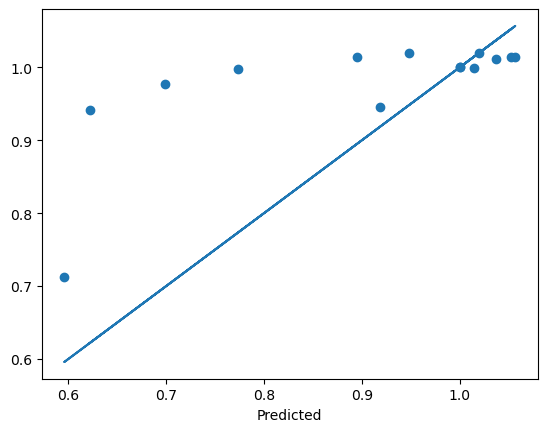

In [ ]:
model.eval()
all_pred = [[] for _ in range(10)]
all_true = [[] for _ in range(10)]

with torch.no_grad():
    for exp in val_loader:
        init_state = exp['init_state']
        measured_states = exp['measured_state']
        times = exp['times']

        pred_states, measured_indices = model(init_state, times)

        pred_values = pred_states[measured_indices]
        measured_values = measured_states.squeeze(0)

        for col in range(measured_values.shape[1]):
            all_pred[col].append(pred_values[:,col])
            all_true[col].append(measured_values[:,col])

r2_scores= []
for col in range(10):
    col_pred = torch.cat(all_pred[col], dim=0)
    col_true = torch.cat(all_true[col], dim=0)
    col_r2 = r2_score(col_pred, col_true)
    r2_scores.append(col_r2)

avg_r2 = np.mean(r2_scores)
print(avg_r2)
ind = 7
pred = torch.cat(all_pred[ind], dim=0)
true = torch.cat(all_true[ind], dim=0)
plt.scatter(true, pred)
plt.plot(true,true)
plt.xlabel('Predicted')

In [ ]:
def evaluate_model(model, val_loader):
    model.eval()
    all_predictions = []
    all_true_values = []

    with torch.no_grad():
        for exp in val_loader:
            init_state = exp['init_state']
            measured_states = exp['measured_state']
            times = exp['times']

            pred_states, measured_indices = model(init_state, times)
            pred_values = pred_states[measured_indices]

            all_predictions.append(pred_values)
            all_true_values.append(measured_states)
            
    all_predictions = torch.cat(all_predictions, dim=0)
    all_true_values = torch.cat(all_true_values, dim=0)

    r2_scores= []
    for col in range(all_true_values.shape[1]):
        col_r2 = r2_score(all_predictions[:,col], all_true_values[:,col])
        r2_scores.append(col_r2)

    avg_r2 = np.mean(r2_scores)
    return avg_r2